In [1]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import pandas as pd

from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.ConsumptionSaving.ConsIndBequestModel import (
    TerminalBequestConsumerType,
    init_lifecycle,
)
from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
from HARK.utilities import plot_funcs

In [2]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to, age=birth_age, education=education, wave=1995
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True, cross_sec=True, year=2004, min_age=birth_age, max_age=death_age - 1
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_lifecycle)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": liv_prb})

In [3]:
# Make and solve an idiosyncratic shocks consumer with a finite lifecycle
LifecycleExample = TerminalBequestConsumerType(**params)
# Make this consumer live a sequence of periods exactly once
LifecycleExample.cycles = 1

In [4]:
start_time = time()
LifecycleExample.solve()
end_time = time()
print(f"Solving a lifecycle consumer took {end_time - start_time} seconds.")
LifecycleExample.unpack("cFunc")

Solving a lifecycle consumer took 0.17333745956420898 seconds.


Consumption functions while working:


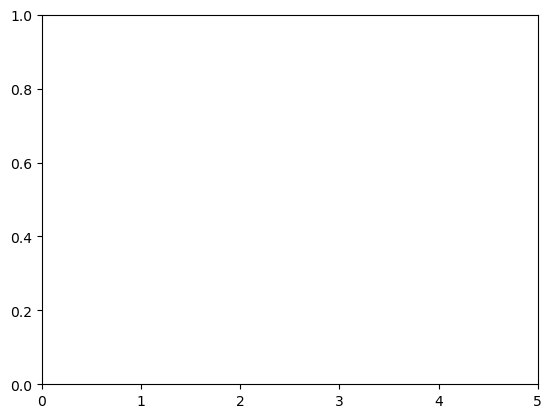

In [5]:
# Plot the consumption functions during working life
print("Consumption functions while working:")
mMin = min(
    [LifecycleExample.solution[t].mNrmMin for t in range(LifecycleExample.T_cycle)]
)
plot_funcs(LifecycleExample.cFunc[: LifecycleExample.T_retire], mMin, 5)

Consumption functions while retired:


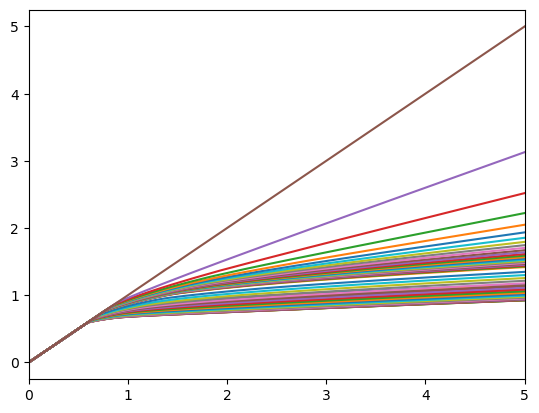

In [6]:
# Plot the consumption functions during retirement
print("Consumption functions while retired:")
plot_funcs(LifecycleExample.cFunc[LifecycleExample.T_retire :], 0, 5)

In [7]:
# Number of LifecycleExamples and periods in the simulation.
LifecycleExample.LifecycleExampleCount = 500
LifecycleExample.T_sim = 200

# Set up the variables we want to keep track of.
LifecycleExample.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
LifecycleExample.initialize_sim()
LifecycleExample.simulate()

{'aNrm': array([[ 0.28209054,  0.95160955,  0.34891832, ...,  0.46209942,
          0.21659388,  2.22032464],
        [ 0.34823176,  0.59356967,  1.17610209, ...,  1.40708593,
          0.19464725,  1.5612364 ],
        [ 0.67112415,  1.46006124,  1.18974078, ...,  1.28670904,
          0.39932477,  1.14337123],
        ...,
        [ 1.91613274, 34.17843718,  5.18490024, ...,  7.68508082,
          9.68140706,  1.77630058],
        [ 1.60549363, 31.70304561,  5.1673588 , ..., 10.48912419,
         10.78617008,  2.633709  ],
        [ 2.31289468, 29.24143416,  7.26313731, ..., 12.063152  ,
          8.29084327,  1.82705051]]),
 'cNrm': array([[0.84072933, 0.95525117, 0.86100528, ..., 0.88722666, 0.81602437,
         1.05692601],
        [0.85084953, 0.89826064, 0.96106569, ..., 0.97973102, 0.79820987,
         0.99147094],
        [0.90093724, 0.97212052, 0.95137363, ..., 0.95904255, 0.85707043,
         0.94760677],
        ...,
        [1.00418516, 4.62164117, 1.00444501, ..., 1.1390

In [8]:
raw_data = {
    "Age": LifecycleExample.history["t_age"].flatten() + birth_age - 1,
    "pIncome": LifecycleExample.history["pLvl"].flatten(),
    "nrmM": LifecycleExample.history["mNrm"].flatten(),
    "nrmC": LifecycleExample.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

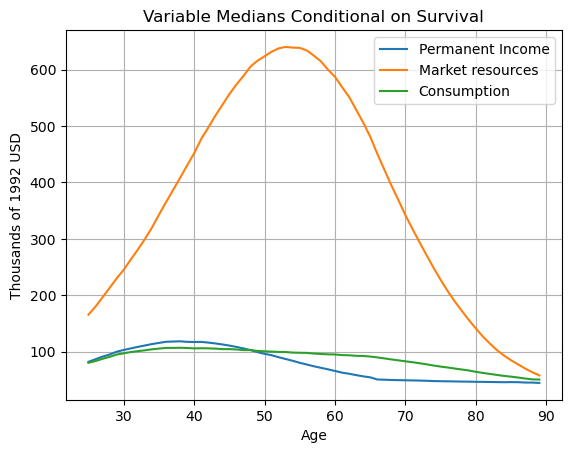

In [9]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Thousands of {} USD".format(adjust_infl_to))
plt.title("Variable Medians Conditional on Survival")
plt.grid()